In [1]:
import numpy as np
import json, os
from datetime import datetime

class ESDIRK23:
    def __init__(self, gamma:float=(1-(1/2**0.5)), rtol=1e-6, atol=1e-9, h_init=1e-2, h_min=1e-6, h_max=1.0, max_iter=10, tol=1e-8):
        self.gamma = gamma
        self.rtol = rtol
        self.atol = atol
        self.h_init = h_init
        self.h_min = h_min
        self.h_max = h_max
        self.max_iter = max_iter
        self.tol = tol
        self.info = {'JacDir_ki_diff':[], 'ESDIRK_k': [], 't':[], 'step_evals':0, 'accepted_iter':0, 'rejected_iter':0, 'h_step_width':[], 'rel_err_norm':[self.rtol], 'iter':[]}

        # ESDIRK23 constant properties
        self.p = 2      # integrated order
        self.phat = 3   # embedded order
        self.s = 3      # stages

        # Coefficients for ESDIRK23 (L-stable); common choice gamma = 1 - 1/sqrt(2) = 0.2928932188134524
        self.c = [0, 2*self.gamma, 1.0]
        self.A = np.array([
            [0, 0, 0],
            [self.gamma, self.gamma, 0],
            [(1-self.gamma)/2, (1-self.gamma)/2, self.gamma]
        ])
        self.b = np.array([(1-self.gamma)/2, (1-self.gamma)/2, self.gamma])
        self.b_hat = np.array([(6*self.gamma-1)/(12*self.gamma), 1/(12*self.gamma*(1-2*self.gamma)), (1-3*self.gamma)/(3*(1-2*self.gamma))])  # higher-order embedded for error estimate
        self.e = self.b - self.b_hat

    def step(self, f, t, y, jac=None, params=None, h=None):
        if h is None:
            h = self.h_init
        s = len(self.c)
        k = [np.zeros_like(y) for _ in range(s)]
        self.info['step_evals'] += 1

        # iter through stages
        for i in range(s):
            ti = t + self.c[i] * h
            yi = y.copy()
            for j in range(i):
                yi += h * self.A[i][j] * k[j]

            # Solve implicit equation: ki = f(ti, yi + h * a_ii * ki)
            ki = f(ti, yi, *params) if params else f(ti, yi)
            for _ in range(self.max_iter):
                g = f(ti, yi + h * self.A[i][i] * ki, *params) if params else f(ti, yi + h * self.A[i][i] * ki)
                if jac:
                    J = jac(ti, yi + h * self.A[i][i] * ki, *params) if params else jac(ti, yi + h * self.A[i][i] * ki)
                    I = np.eye(len(y))
                    res = ki - g
                    #print("res:", res, "J", J, "ki", ki, "g", g)
                    #print('solve matrix:', I - h * self.A[i][i] * J)
                    dki = np.linalg.solve(I - h * self.A[i][i] * J, res)
                    ki_new = ki - dki
                else:
                    ki_new = g  # basic fixed-point update

                ki_diff = np.linalg.norm(ki_new - ki)
                self.info['JacDir_ki_diff'].append(ki_diff)
                if  ki_diff < self.tol:
                    break
                ki = ki_new
            
            k[i] = ki
            self.info['ESDIRK_k'].append(ki.tolist())

        y_new = y + h * sum(self.b[i] * k[i] for i in range(s))
        y_hat = y + h * sum(self.b_hat[i] * k[i] for i in range(s))
        err = np.linalg.norm((y_new - y_hat) / (self.atol + self.rtol * np.abs(y_new)), ord=np.inf)
        return y_new, err

    def integrate_adaptive(self, f, t0, y0, tf, jac=None, params=None, verbose=False, save_traces:bool=True, save_trace_path:str="./traces"):
        self.info['t'].append(t0)
        save_path = os.path.join(save_trace_path, 'ESDIRK23_adaptive_'+datetime.now().strftime('%d_%m_%Y__%H_%M_%S')+'.json')
        y_vals = [np.array(y0)]
        t, y, iter_ = t0, np.array(y0), 1
        h = self.h_init

        while t < tf:
            self.info['h_step_width'].append(h)
            h = min(h, tf - t)

            try:
                y_new, err_norm_tol = self.step(f, t, y, jac=jac, params=params, h=h)
                self.info['rel_err_norm'].append(err_norm_tol)
            except Exception as e:
                raise RuntimeError(f"ESDIRK23 integration step failed at t={t} with h={h}: {e}")

            # accept step
            if err_norm_tol <= 1:
                self.info['accepted_iter'] += 1
                t += h
                y = y_new
                self.info['t'].append(t)
                y_vals.append(y.copy())

                # Adapt step size aggressively if error is small
                if err_norm_tol == 0:
                    h_new = h * 2.0
                else:
                    h_new = h * min(5.0, max(1.5, 0.9 * (1 / err_norm_tol)**0.3))

                h = min(self.h_max, h_new)
            else:
                # Reject step and shrink
                self.info['rejected_iter'] += 1
                h = max(self.h_min, h * max(0.1, 0.9 * (1 / err_norm_tol)**0.25))

            # Guard against vanishing h
            if h < 1e-12:
                raise RuntimeError("Step size too small — integration may be stuck.")

            iter_+=1
            if iter_%500==0 and verbose: print(f"Iteration {iter_}, err: {err_norm_tol}, h: {h}, t: {t}")
            if iter_%1000==0:
                with open(save_path, 'w') as fp:
                    json.dump(self.info, fp)

        return np.array(y_vals), self.info
    
    def integrate_fixed(self, f, t0, y0, tf, h, jac=None, params=None, verbose:bool=False):
        self.info['t'].append(t0)
        y_vals = [np.array(y0)]
        t, y, iter_ = t0, np.array(y0), 1

        while t < tf:
            h = min(h, tf - t)
            self.info['h_step_width'].append(h)
            y, err_norm  = self.step(f, t, y, jac=jac, params=params, h=h)
            t += h
            self.info['t'].append(t)
            self.info['rel_err_norm'].append(err_norm)
            y_vals.append(y.copy())
            iter_+=1
            if verbose: print(f'iteration: {iter_}')

        return np.array(y_vals), self.info


___________

RUN

### Predator Prey

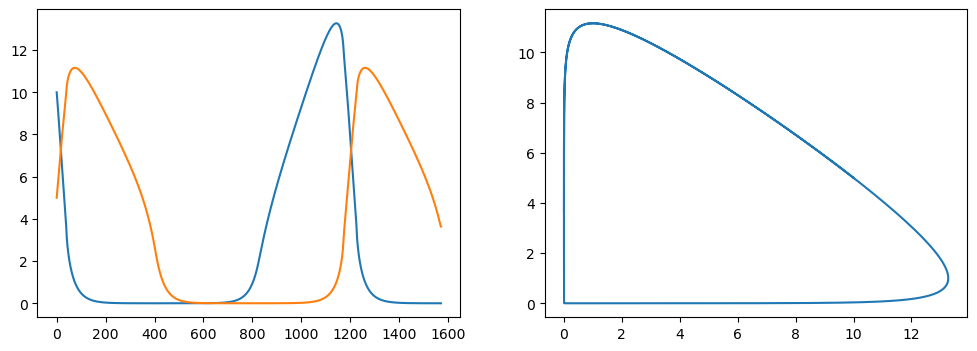

In [16]:
import matplotlib.pyplot as plt
from models import PreyPredator, PreyPredator_Jac

y0=[10.0, 5.0]
solver = ESDIRK23(h_init=0.01)
res = solver.integrate_adaptive(PreyPredator, t0=0, y0=y0, tf=20, jac=PreyPredator_Jac)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])
plt.subplot(1,2,2)
plt.plot(res[0][:, 0], res[0][:, 1])

### Lotka Volterra

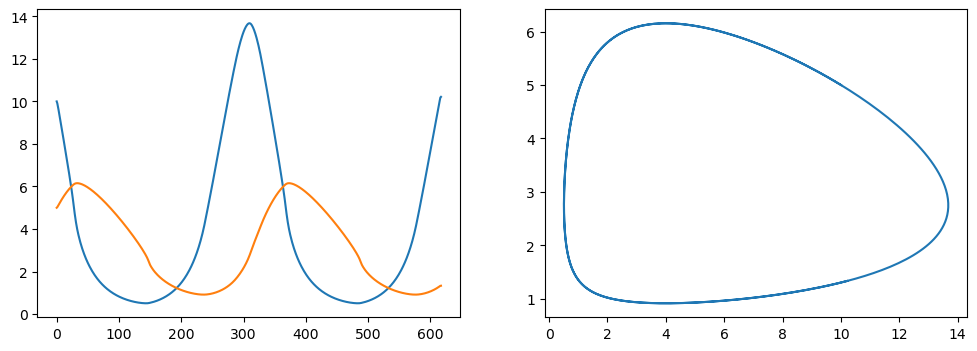

In [4]:
import matplotlib.pyplot as plt
from models import LotkaVolterra, LotkaVolterra_Jac

y0=[10.0, 5.0]
solver = ESDIRK23(h_init=0.01)
res = solver.integrate_adaptive(LotkaVolterra, t0=0, y0=y0, tf=20, jac=LotkaVolterra_Jac)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])
plt.subplot(1,2,2)
plt.plot(res[0][:, 0], res[0][:, 1])

### Van der Pol

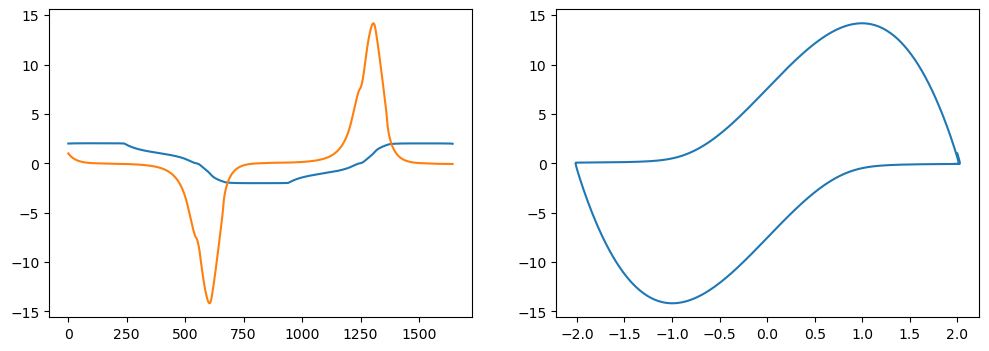

In [5]:
from models import VanDerPol, VanDerPol_Jac

solver = ESDIRK23()
res = solver.integrate_adaptive(VanDerPol, t0=0, y0=[2.0, 1.0], tf=20, jac=VanDerPol_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])
plt.subplot(1,2,2)
plt.plot(res[0][:, 0], res[0][:, 1])

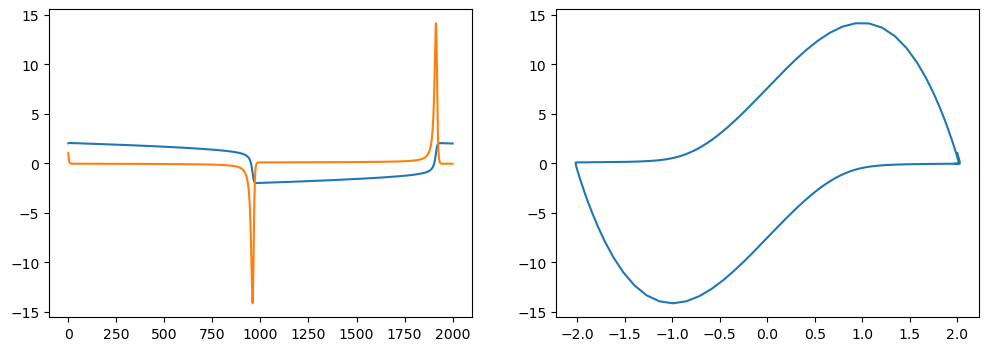

In [73]:
solver = ESDIRK23(h_init=0.01)
res = solver.integrate_fixed(VanDerPol, t0=0, y0=[2.0, 1.0], tf=20, jac=VanDerPol_Jac, h=0.01)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])
plt.subplot(1,2,2)
plt.plot(res[0][:, 0], res[0][:, 1])

### CSTR3

In [2]:
from models import CSTR3, CSTR3_Jac

#C0 = np.array([1.6/2, 2.4/2, 600]) 
#C0 = np.array([2.4, 4.1, 300]) -> works!
#C0 = np.array([2.4, 3.1, 200]) 
C0 = np.array([1.4, 3.7, 200]) 
solver = ESDIRK23(h_init=0.01)
#res = solver.integrate_fixed(CSTR3, t0=0, y0=C0, tf=20, jac=CSTR3_Jac, h=0.001)
res = solver.integrate_adaptive(CSTR3, t0=0, y0=C0, tf=20, jac=CSTR3_Jac, verbose=True)

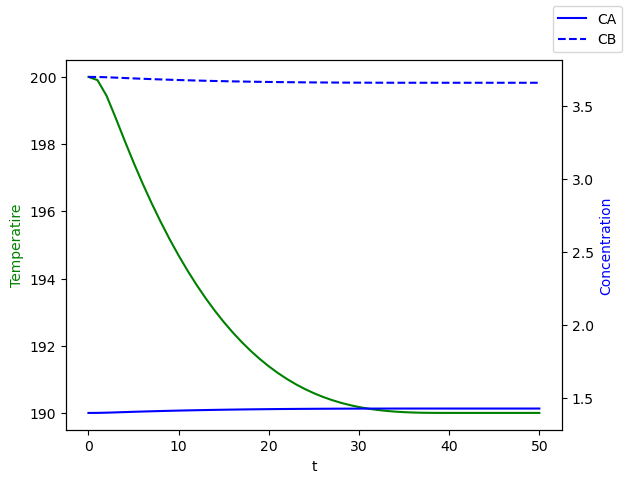

In [3]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(res[0][:,2], 'g-')
ax2.plot(res[0][:,0], 'b', linestyle='-', label='CA')
ax2.plot(res[0][:,1], 'b', linestyle='--', label='CB')

ax1.set_xlabel('t')
ax1.set_ylabel('Temperatire', color='g')
ax2.set_ylabel('Concentration', color='b')
fig.legend()

**14.05.2025: Jacobian Singularity Error**

**Troubleshooting:**

- same $C_0$ and $C_in$ is a problem! -> perfect steady state initially:

$$\frac{dC}{dt} = \frac{F}{V}(C_{in}-C) + \mathbf{v} \cdot r $$

- If cond(J) > 1e12, the matrix is effectively singular numerically and you should perturb the system or regularize.
- ideally we want a low condition number

**Solution:**
- essentially, the initial values sucked
- they were too close to steady state
- one could try to find a more robust implementation of ESDIRK23, that finds a well conditioned Jacobian for an initial state

In [41]:
#J = CSTR3_Jac(0, np.array([1.4, 3.1, 400]))
J = CSTR3_Jac(0, np.array([2.4, 3.1, 200]))
np.linalg.cond(J)

1.0000099960271578

In [78]:
C0, h = np.array([1.6/2, 2.4/2, 600]), 0.01
J, I = CSTR3_Jac(0, C0), np.eye(3)
ki = CSTR3(0, C0)
g = CSTR3(0, C0+h*solver.A[0][0]*ki)
res = ki-g
np.linalg.solve(I-h*solver.A[0][0]*J, res)

array([0., 0., 0.])

In [85]:
solve_m = np.array([[-3.80808734e+20, -1.90404367e+20, 1.34284191e+08],
 [-7.61617467e+20, -3.80808734e+20,  2.68568382e+08],
 [ 5.09443122e+22,  2.54721561e+22,  1.79644403e+10]])

np.linalg.inv(solve_m)

array([[-1.99999993e-12,  9.99999965e-13, -2.94197039e-30],
       [ 3.99999986e-12, -1.99999993e-12,  1.96292825e-23],
       [ 3.72344669e-09, -1.02482711e-16,  2.78327625e-11]])

In [90]:
res = np.array([ 1.75114019e+35,  3.50228039e+35, -2.34266247e+37])
np.linalg.solve(solve_m, res.reshape(-1,1))

array([[ 9.99999954e+14],
       [-2.91969530e+15],
       [-2.87730646e+18]])

##### Try different model implementation

In [ ]:
# Adiabatic CSTR (3-state)
CSTR3_PARAMS = (1.0, 4.186, np.exp(24.6), 8500.0, -560.0, 0.105, 0.8, 1.2, 273.65, 0.1)
def cstr_3_state(t, y, params:tuple=CSTR3_PARAMS):
    CA, CB, T = y
    rho, cP, k0, EaR, dH, V, CAin, CBin, Tin, F = params
    k = k0 * np.exp(-EaR / T)
    r = k * CA * CB
    beta = -dH / (rho * cP)
    return np.array([
        F/V * (CAin - CA) - r,
        F/V * (CBin - CB) - 2 * r,
        F/V * (Tin - T) + beta * r
    ])

def jac_cstr_3_state(t, y, params=CSTR3_PARAMS):
    CA, CB, T = y
    rho, cP, k0, EaR, dH, V, CAin, CBin, Tin, F = params
    k = k0 * np.exp(-EaR / T)
    r = k * CA * CB
    beta = -dH / (rho * cP)

    dkdT = k * (EaR / T**2)
    drdCA = k * CB
    drdCB = k * CA
    drdT = dkdT * CA * CB

    J = np.zeros((3, 3))
    J[0, 0] = -F/V - drdCA
    J[0, 1] = -drdCB
    J[0, 2] = -drdT

    J[1, 0] = -2 * drdCA
    J[1, 1] = -F/V - 2 * drdCB
    J[1, 2] = -2 * drdT

    J[2, 0] = beta * drdCA
    J[2, 1] = beta * drdCB
    J[2, 2] = -F/V + beta * drdT
    return J

In [13]:
C0 = np.array([1.6/2, 2.4/2, 600]) 
solver = ESDIRK23()
res = solver.integrate_adaptive(cstr_3_state, t0=0, y0=C0, tf=20, jac=cstr_3_state)

RuntimeError: ESDIRK23 integration step failed at t=0 with h=0.01: Singular matrix

Still singular matrix?

### CSTR1

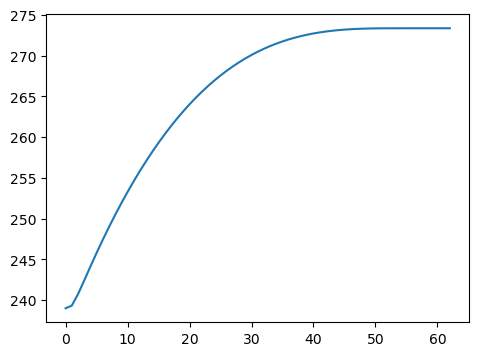

In [8]:
from models import CSTR1, CSTR1_Jac
import numpy as np
import matplotlib.pyplot as plt

# T0 = 273.15 -> works
T0 = 239.0
solver = ESDIRK23(h_init=0.01)
res = solver.integrate_adaptive(CSTR1, t0=0, y0=[T0], tf=20, jac=CSTR1_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

### Brusselator

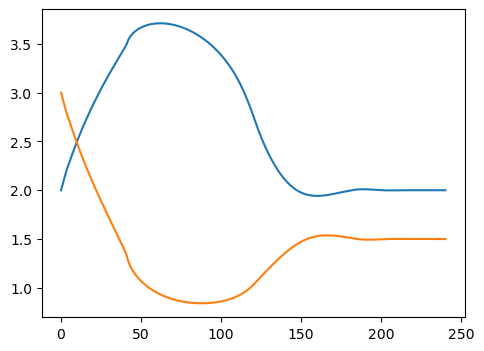

In [3]:
import numpy as np
from models import Brusselator, Brusselator_Jac
import matplotlib.pyplot as plt

y0 = [2.0, 3.0]
solver = ESDIRK23()
res = solver.integrate_adaptive(Brusselator, t0=0, y0=y0, tf=20, jac=Brusselator_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

### Lorentz Attractor

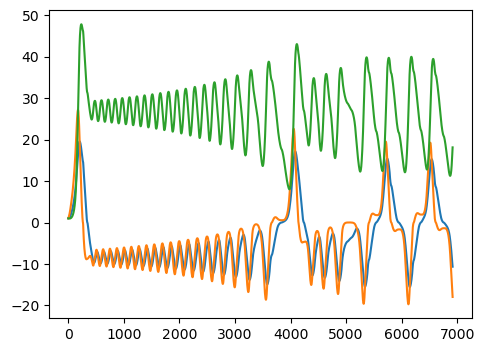

In [7]:
import numpy as np
from models import LorentzAttractor, LorentzAttractor_Jac
import matplotlib.pyplot as plt

y0 = [1.0, 1.0, 1.0]
solver = ESDIRK23()
res = solver.integrate_adaptive(LorentzAttractor, t0=0, y0=y0, tf=20, jac=LorentzAttractor_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

### Robertson

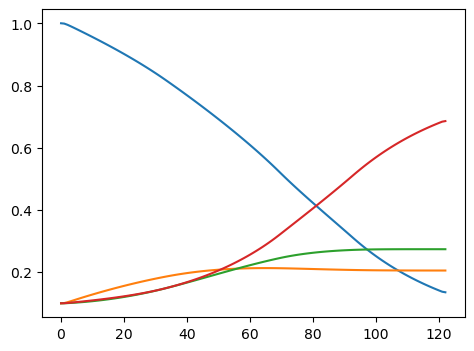

In [4]:
import numpy as np
from models import Robertson, Robertson_Jac
import matplotlib.pyplot as plt

y0 = [1.0, 0.1, 0.1, 0.1]
solver = ESDIRK23()
res = solver.integrate_adaptive(Robertson, t0=0, y0=y0, tf=20, jac=Robertson_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

### PFR-1

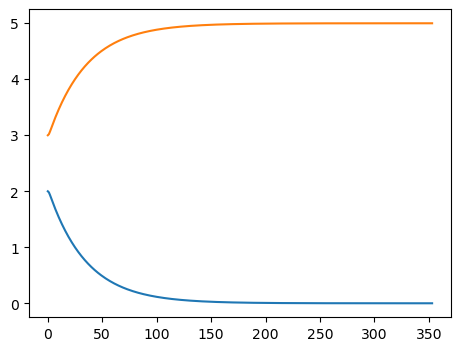

In [5]:
import numpy as np
from models import Robertson, Robertson_Jac
import matplotlib.pyplot as plt

def pfr_single(t, y, params=(1.0,)):
    k, = params
    A, B = y
    r = k * A
    return np.array([-r, r])

def jac_pfr_single(t, y, params=(1.0,)):
    k, = params
    A, _ = y
    return np.array([[-k, 0], [k, 0]])

A, B = 2.0, 3.0 # initial concentration of substances
y0 = [A, B]
solver = ESDIRK23()
res = solver.integrate_adaptive(pfr_single, t0=0, y0=y0, tf=20, jac=jac_pfr_single)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

...but not quite what was in the paper :/

### PFR-3

In [20]:
import numpy as np
from models import PFR3, CSTR3
import matplotlib.pyplot as plt
from autograd import jacobian

# initial conditions
Nz = 10
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# try with auto jacobian
jac = jacobian(CSTR3)
solver = ESDIRK23()
res = solver.integrate_adaptive(PFR3, t0=0, y0=C0, tf=20, jac=jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

RuntimeError: ESDIRK23 integration step failed at t=0 with h=0.01: too many values to unpack (expected 3)

### Hovorka

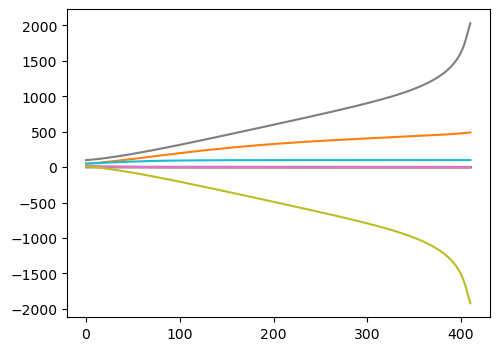

In [3]:
import numpy as np
from models import Hovorka, Hovorka_Jac
import matplotlib.pyplot as plt

y0 = [5.0, 50.0, 1.0, 1.0, 1.0, 10.0, 10.0, 100.0, 10.0, 50.0]
solver = ESDIRK23()
res = solver.integrate_adaptive(Hovorka, t0=0, y0=y0, tf=20, jac=Hovorka_Jac)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res[0])

### Hovorka Enhanced

- Pancreatic feedback: Nonlinear β-cell stimulation.
- Insulin-dependent glucose uptake: Added saturation effects.
- Hepatic glucose production suppression via insulin.
- Glycogen storage and mobilization: In both liver and muscle.


In [ ]:
import numpy as np
from models import Hovorka_, Hovorka_Jac_
import matplotlib.pyplot as plt

y0 = [5.0, 50.0, 1.0, 1.0, 1.0, 10.0, 10.0, 100.0, 10.0, 50.0]
solver = ESDIRK23()
res = solver.integrate_adaptive(Hovorka_, t0=0, y0=y0, tf=15, jac=Hovorka_Jac_)

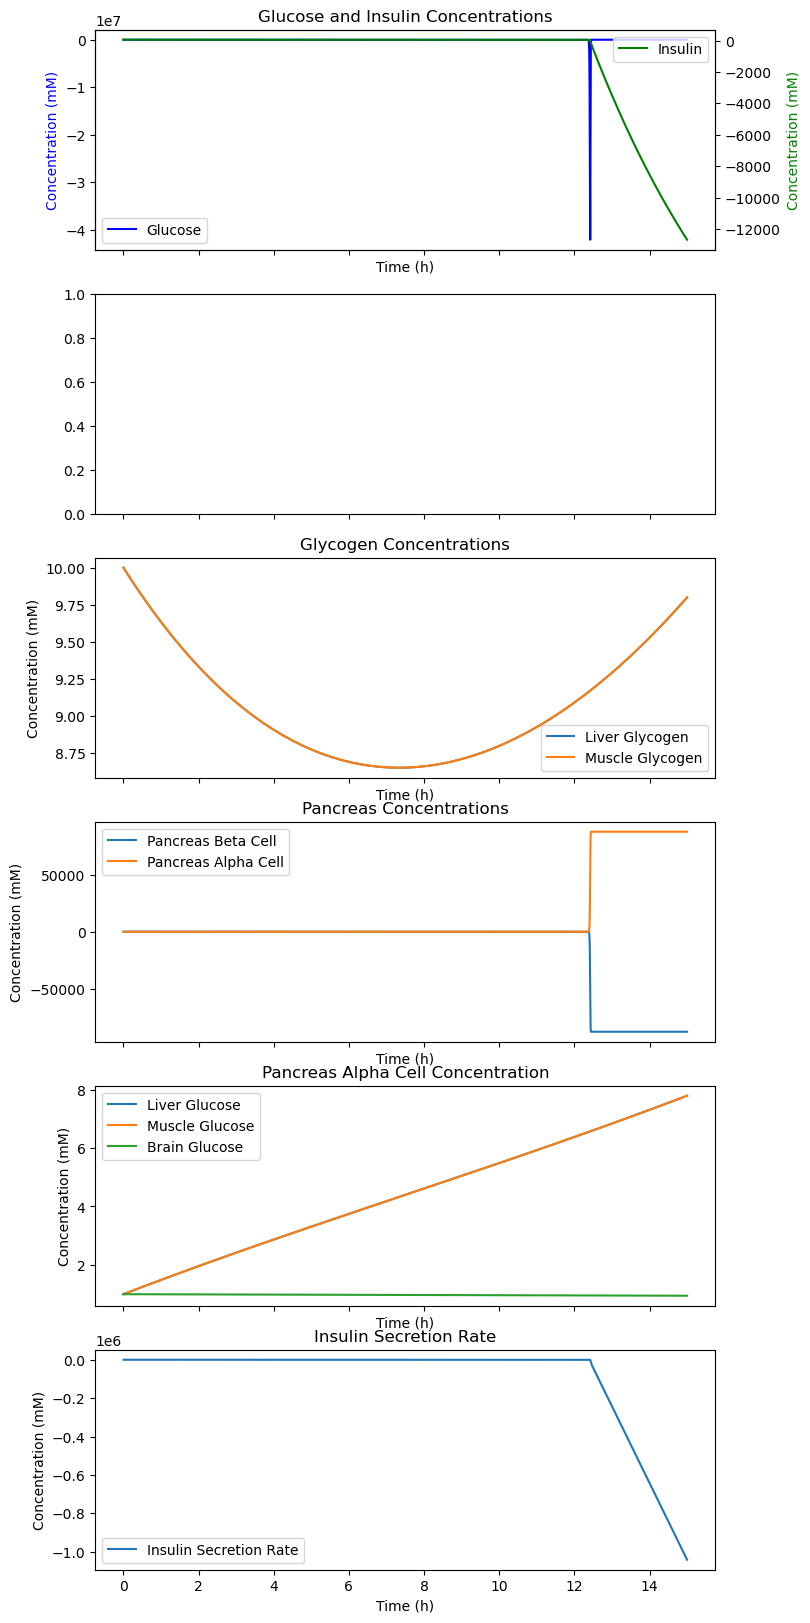

In [8]:
t = res[1]['t']
solution = res[0]

# Extract variables for plotting
Glucose = solution[:, 0]
Insulin = solution[:, 1]
LiverGlucose = solution[:, 2]
MuscleGlucose = solution[:, 3]
BrainGlucose = solution[:, 4]
LiverGlycogen = solution[:, 5]
MuscleGlycogen = solution[:, 6]
PancreasBetaCell = solution[:, 7]
PancreasAlphaCell = solution[:, 8]
InsulinSecretionRate = solution[:, 9]

# Plot the results
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(8, 20))

ax[1] = ax[0].twinx()
ax[1].plot(t, Insulin, label='Insulin', c='g')
ax[1].set_ylabel('Concentration (mM)', color='g')
ax[1].legend()
ax[0].plot(t, Glucose, label='Glucose', c='b')
ax[0].set_ylabel('Concentration (mM)', color='b')
ax[0].set_xlabel('Time (h)')
ax[0].set_title('Glucose and Insulin Concentrations')
ax[0].legend()

ax[2].plot(t,LiverGlycogen, label='Liver Glycogen')
ax[2].plot(t, MuscleGlycogen, label='Muscle Glycogen')
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('Concentration (mM)')
ax[2].set_title('Glycogen Concentrations')
ax[2].legend()

ax[3].plot(t, PancreasBetaCell, label='Pancreas Beta Cell')
ax[3].plot(t, PancreasAlphaCell, label='Pancreas Alpha Cell')
ax[3].set_xlabel('Time (h)')
ax[3].set_ylabel('Concentration (mM)')
ax[3].set_title('Pancreas Concentrations')
ax[3].legend()

ax[4].plot(t, LiverGlucose, label='Liver Glucose')
ax[4].plot(t, MuscleGlucose, label='Muscle Glucose')
ax[4].plot(t, BrainGlucose, label='Brain Glucose')
ax[4].set_xlabel('Time (h)')
ax[4].set_ylabel('Concentration (mM)')
ax[4].set_title('Pancreas Alpha Cell Concentration')
ax[4].legend()

ax[5].plot(t, InsulinSecretionRate, label='Insulin Secretion Rate')
ax[5].set_xlabel('Time (h)')
ax[5].set_ylabel('Concentration (mM)')
ax[5].set_title('Insulin Secretion Rate')
ax[5].legend()

In [9]:
import json
f = open('./traces/ESDIRK23_adaptive_14_05_2025__15_04_44.json', 'r')
trace = json.load(f)

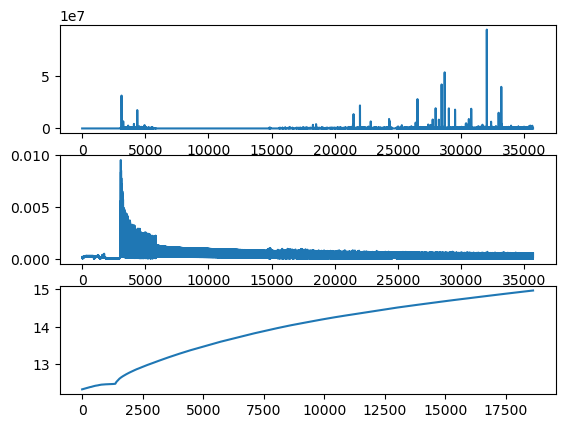

In [10]:
plt.subplot(3,1,1)
plt.plot(trace['rel_err_norm'][300:50000])
plt.subplot(3,1,2)
plt.plot(trace['h_step_width'][300:50000])
plt.subplot(3,1,3)
plt.plot(trace['t'][300:50000])